1RSB cavity equations at Parisi parameter $m=1$
---
We want to solve numerically the following equations:
\begin{align}
	\bar{P}_{\sigma}(th|\bar{th})\mathcal{P}^{RS}(\bar{th}) &= \sum_d\tilde{\Lambda}_d\int \prod_{i=1}^d {\rm d} \mathcal{Q}^{RS}(\bar{tu}_i)\delta[\bar{th}-f(\bar{tu}_1,\dots,\bar{tu}_d,H)]\int\prod_{i=1}^d \bar{Q}_{\sigma}(tu_i|\bar{tu}_i)\delta[th-f(tu_1,\dots,tu_d,H)] \\
	\bar{Q}_{\sigma}(tu|\bar{tu})\mathcal{Q}^{RS}(\bar{tu}) &= \sum_k \tilde{K}_k\sum_s \frac{1}{2} \int \prod_{i=1}^k {\rm d} \mathcal{P}^{RS}(\bar{th}_i)\delta[\bar{tu}-g(\bar{th}_1,\dots,\bar{th}_k,s)] \\
	&\times \sum_{\sigma_1,\dots,\sigma_k}\nu(\sigma_1,\dots,\sigma_k|\bar{h}_1,\dots,\bar{h}_k,s,\sigma)\int \prod_{i=1}^k {\rm d} \bar{P}_{\sigma_i}(th_i|\bar{th}_i)\delta[tu-g(th_1,\dots,th_k,s)] 
\end{align}
where
\begin{align}
	\nu(\sigma_1,\dots,\sigma_k|\bar{th}_1,\dots,\bar{th}_k,s,\sigma) = \frac{\mathbb{I}[\sigma\prod_{i=1}^k\sigma_i=s]\prod_{i=1}^k(1+\sigma_i\bar{th}_i)}{\sum_{\sigma_1,\dots\sigma_d}\mathbb{I}[\sigma\prod_{i=1}^k\sigma_i=s]\prod_{i=1}^k(1+\sigma_i\bar{th}_i)}
\end{align}

Parametrization of the BP equations:
---
The BP equations are written as 
\begin{align}
    m_{ia}(\sigma_i)&=\frac{e^{H\sigma_i}\prod_{b\in\partial i \setminus a}\hat{m}_{bi}(\sigma_i)}{e^{\sigma_i}\prod_{b\in\partial i \setminus a}\hat{m}_{bi}(+)+e^{-H}\prod_{b\in\partial i \setminus a}\hat{m}_{bi}(-)} \\
    \hat{m}_{ai}(\sigma_i)&=\sum_{\{\sigma_j\}_{j\in\partial a \setminus i}}\mathbb{I}\left[\sigma_i\prod_{j\in\partial a\setminus i}\sigma_j=s_a\right]\prod_{j\in\partial a\setminus i}m_{ja}(\sigma_j)
\end{align}
In the equations above we have used the following parametrization:
\begin{align}
    m(\sigma)=\frac{1+\sigma th}{2}, \quad \hat{m}(\sigma)=\frac{1+\sigma tu}{2}
\end{align}
The BP equations are re-written in this parametrization:
\begin{align}
    th=f(tu_1,\dots,tu_d,H)=\frac{e^{H}\prod_{i=1}^k(1+tu_i) - e^{-H}\prod_{i=1}^k(1-tu_i)}{e^{H}\prod_{i=1}^k(1+tu_i) + e^{-H}\prod_{i=1}^k(1-tu_i)}, \quad tu = g(th_1,\dots,th_k,s) = s\prod_{i=1}^k th_i
\end{align}

Numerical implementation
---
In this notebook we use instead the pairs $(m(+),m(-)), (\hat{m}(+), \hat{m}(-))$ to parametrize the BP messages. For instance the distribution $\mathcal{P}^{RS}$ is represented by an array of size 'popsize', each element being a pair (1st element is $m(+)$, 2nd element is $m(-)$.

The joint distribution $\bar{P}_{\sigma}(m|\bar{m})\mathcal{P}^{RS}(\bar{m})$ is represented by the population of couples $(m^{\sigma},\bar{m})$, which is stored as two arrays of size 'popsize'.

In the code below, we thus have a population 'popP' that is a set of 3 arrays indiced from -1 to 1. The array popP[0] corresponds to the distribution $\mathcal{P}^{RS}$. The couple of arrays (popP[-1],popP[0]) corresponds to the distribution $\bar{P}_-(m|\bar{m})\mathcal{P}^{RS}(\bar{m})$ while the couple of arrays (popP[1],popP[0]) corresponds to the distribution $\bar{P}_+(m|\bar{m})\mathcal{P}^{RS}(\bar{m})$

In [1]:
using OffsetArrays

* Two ways of writing the BP functions (one with convolutions)

In [2]:
function BP_th(H, tus)
    p1 = prod(tus[i][1] for i=1:length(tus))*exp(H)
    p2 = prod(tus[i][2] for i=1:length(tus))*exp(-H)
    if p1+p2==0
        println("conflicting messages in BP_th")
    end
    th1 = p1/(p1+p2)
    th2 = p2/(p1+p2)
    (th1, th2)
end

function BP_tu(s, ths)
    tu1=0.0; tu2=0.0
    for sig in Iterators.product(fill(-1:2:1,2)...)
        ind = [(sig[i]==1 ? 1 : 2) for i=1:length(sig)]
        if prod(sig) == s
            tu1 += prod(ths[i][ind[i]] for i=1:length(ths))
        else
            tu2 += prod(ths[i][ind[i]] for i=1:length(ths))
        end
    end
    (tu1, tu2)
end

BP_tu (generic function with 1 method)

In [3]:
conv(h1::Tuple, h2::Tuple) = tuple(h1[1]*h2[1]+h1[2]*h2[2], h1[1]*h2[2]+h1[2]*h2[1]) 
function BP_th_conv(H, tus)
    th = (exp(H), exp(-H))
    for tu in tus
        th = th.*tu
    end
    th ./ sum(th)
end
function BP_tu_conv(s, ths)
   tu = s==1 ? tuple(1.0,0.0) : tuple(0.0,1.0)
   for i in eachindex(ths)
       tu = conv(tu, ths[i]) 
    end
    tu
end

BP_tu_conv (generic function with 1 method)

* Writing the distribution $\nu(\sigma_1,\dots,\sigma_k|\bar{th}_1,\dots,\bar{th}_k,s,\sigma) = \frac{\mathbb{I}[\sigma\prod_{i=1}^k\sigma_i=s]\prod_{i=1}^k m_i(\sigma_i)}{\sum_{\sigma_1,\dots\sigma_d}\mathbb{I}[\sigma\prod_{i=1}^k\sigma_i=s]\prod_{i=1}^k m_i(\sigma_i)}$

In [4]:
function dist_sigmas(s, ths_0, σs, ν)
    k = length(ths_0)
    i = 0
    for sig in Iterators.product(fill(-1:2:1,k)...)
        i += 1
        ind = [(sig[j]==1 ? 1 : 2) for j=1:length(sig)]
        σs[i] = sig
        if prod(sig) == s
            ν[i] += prod(ths_0[j][ind[j]] for j=1:length(ths_0))
        end
    end
    ν ./= sum(ν)
    ν, σs
end

dist_sigmas (generic function with 1 method)

* First we write a function just to iterate the RS cavity equations:
\begin{align}
	\mathcal{P}^{RS}(\bar{th}) &= \sum_d\tilde{\Lambda}_d\int \prod_{i=1}^d {\rm d} \mathcal{Q}^{RS}(\bar{tu}_i)\delta[\bar{th}-f(\bar{tu}_1,\dots,\bar{tu}_d,H)] \\
	\mathcal{Q}^{RS}(\bar{tu}) &= \sum_k \tilde{K}_k\sum_s \frac{1}{2} \int \prod_{i=1}^k {\rm d} \mathcal{P}^{RS}(\bar{th}_i)\delta[\bar{tu}-g(\bar{th}_1,\dots,\bar{th}_k,s)] 
\end{align}
* Once we will obtain a fixed point of this equations, we will use it for the initialization of the 1RSB cavity equations.

In [5]:
using StatsBase, ProgressMeter, Random
residual(x) = (p=OffsetVector((x .* eachindex(x))[1:end], 0:lastindex(x)-1); p./=sum(p))

residual (generic function with 1 method)

In [6]:
function RS(Λ, K, H; 
        maxiter=100, 
        popsize=1000, 
        popP_RS = fill((0.5,0.5), 1:popsize),
        popQ_RS = fill((0.5,0.5), 1:popsize),
        q0 = fill(NaN, 1:maxiter)
    )

    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)

    
    @showprogress for t = 1:maxiter
        
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP_RS[ind_ths]            
            s = rand((-1,1))
            popQ_RS[i] = BP_tu_conv(s, ths)
        end
        
        q0[t]=0.0
        
        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            ind_tus = rand(1:popsize, d)
            tus = popQ_RS[ind_tus]
            popP_RS[i] = BP_th_conv(H, tus)
            
            q0[t]+=(popP_RS[i][1]-popP_RS[i][2])^2
        end
        
        q0[t] = q0[t]/length(popP_RS)
    end
    popP_RS, popQ_RS, q0
end

RS (generic function with 1 method)

* Initialization of the populations popP, popQ: 

The array popP[0] representing the RS distribution is filled with the solution of the RS equation.

The arrays popP[$\sigma$] are filled either with $(m_i^{\sigma}(\sigma)=1-\epsilon, m_i^{\sigma}(-\sigma)=\epsilon)$ for each elements i in 1:popsize (function init_pop). This corresponds to set $th^{\sigma}=\sigma\times(1-2\epsilon)$

Or each element m_i of popP[$\sigma$] is set to $m_i(\sigma)=1,m_i(-\sigma)=0)$ with probability $1-\epsilon$, and $m_i=\bar{m}_i$ with probability $\epsilon$ (with $\bar{m}_i$ the i^th element in popP[0]). (function init_pop_alternative)

In [7]:
function init_pop(pop_RS, ϵ)
    N=length(pop_RS)
    pop = fill((NaN, NaN), -1:1, 1:N)
    pop[0,:]=popP_RS
    pop[1,:] =fill( ( 1-ϵ, ϵ), 1:N)
    pop[-1,:] = fill( ( ϵ, 1-ϵ), 1:N)
    pop
end
function init_pop_alternative(pop_RS, ϵ)
    N=length(pop_RS)
    pop = fill((NaN, NaN), -1:1, 1:N)
    pop[0,:]=popP_RS
    for i=1:N
        pop[1,i]=(rand()<ϵ ? pop[0,i] : (1.0, 0.0))
        pop[-1,i]=(rand()<ϵ ? pop[0,i] : (0.0, 1.0))
    end
    pop
end

init_pop_alternative (generic function with 1 method)

* Writing functions to check whether the solution to the 1RSB equations is the RS solution or not:

The trivial RS solution corresponds to have 
\begin{align}
    \bar{P}_{\sigma}(m|\bar{m})\mathcal{P}^{RS}(\bar{m})=\delta(m-\bar{m})\mathcal{P}^{RS}
\end{align}
and similarly for $\bar{Q}_{\sigma}$

The function checkRS computes the quantities $q_0$ and $q_1$ defined in equations (38) of the article by A. Montanari, F. Ricci-Tersenghi and G. Semerjian. Having $q_1-q_0=0$ corresponds to the RS trivial solution, while having $q_1-q0>0$ corresponds to a non-trivial solution.

In the function checkRS_comparePops we just check on the populations whether we get a delta function (i.e whether for each element $i$ of the population we have $m_i^{\sigma}=\bar{m}_i$)

In [8]:
function checkRS(popP)
    q0=0.0; q1=0.0
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        m0 = th[0][1]-th[0][2]; m1 = th[1][1]-th[1][2]; mm1=th[-1][1]-th[-1][2]
        q0 += m0^2
        q1 += m1*th[0][1] - mm1*th[0][2]
    end
    q1= q1/size(popP, 2); q0=q0/size(popP, 2)
    q0, q1, q1-q0
end

checkRS (generic function with 1 method)

In [9]:
function checkRS_comparePops(popP)
    C1 = [0.0, 0.0]; Cm1=[0.0, 0.0]
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        C1[1] += th[1][1]-th[0][1]
        C1[2] += th[1][2]-th[0][2]
        Cm1[1] += th[-1][1]-th[0][1]
        Cm1[2] += th[-1][2]-th[0][2]
    end
    C1= C1./size(popP, 2); Cm1=Cm1./size(popP, 2)
    C1, Cm1
end

checkRS_comparePops (generic function with 1 method)

* Detect the presence of Hard Fields: 

The function checkHardFields computes how many elements in the population popP[$\sigma$] are hard, i.e are s.t. $m_i^{\sigma}(+)<$xmin, or s.t. $m_i^{\sigma}(-)<$xmin 

In [10]:
function checkHardFields(popP, xmin)
    p1=(0.0, 0.0); pm1=(0.0, 0.0)
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        p1 = p1 .+ (th[1] .< xmin)
        pm1 = pm1 .+ (th[-1] .< xmin)
    end
    p1=p1./size(popP, 2)
    pm1=pm1./size(popP, 2)
    p1, pm1
end

checkHardFields (generic function with 1 method)

* Function that iterates the 1RSB cavity equations at $m=1$. It also stores along the iterations the quantities q0, V$=$q1-q0 (defined in equation (38)), p1 and pm1 that corresponds to the proportions of Hard Fields in the population. 

In [12]:
function RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS; 
        maxiter=100, 
        popsize=1000, 
        ϵ=0.01,
        popP = init_pop(popP_RS, ϵ),
        popQ = init_pop(popQ_RS, ϵ),
        q0=fill(0.0, 1:maxiter),
        V=fill(0.0, 1:maxiter),
        p1=fill((0.0, 0.0), 1:maxiter),
        pm1=fill((0.0, 0.0), 1:maxiter),
        xmin=10^(-20)
    )
    
    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)
    
    @showprogress for t = 1:maxiter
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP[:,ind_ths]            
            s = rand((-1,1))
            popQ[0,i] = BP_tu_conv(s, ths[0,:])
            #@show ind_ths, s
            
            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            ν, σs = dist_sigmas(s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            #@show σ
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            popQ[1,i] = BP_tu_conv(s, elts)

            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            ν, σs = dist_sigmas(-s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            #@show σ
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            popQ[-1,i] = BP_tu_conv(s, elts)
        end

        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            ind_tus = rand(1:popsize, d)
            tus = popQ[:,ind_tus]
            #@show ind_tus
            popP[0,i] = BP_th_conv(H, tus[0,:])
            popP[-1,i] = BP_th_conv(H, tus[-1,:])
            popP[1,i] = BP_th_conv(H, tus[1,:])
            
            m0 = popP[0,i][1]-popP[0,i][2]; m1 = popP[1,i][1]-popP[1,i][2]; mm1 = popP[-1,i][1]-popP[-1,i][2]
            q0[t]+= m0^2
            V[t]+= m1*popP[0,i][1] - mm1*popP[0,i][2]
            p1[t] = p1[t] .+ (popP[1,i] .< xmin)
            pm1[t] = pm1[t] .+ (popP[-1,i] .< xmin)
        end
        
        q0[t] = q0[t]/size(popP, 2)
        V[t] = V[t]/size(popP, 2)
        p1[t] = p1[t]./size(popP, 2)
        pm1[t] = pm1[t]./size(popP, 2)
    end    
    V = V .- q0
    #popP, popQ
    popP, popQ, q0, V, p1, pm1
end

RSB_entropic_m1 (generic function with 1 method)

Test
---

* First find the fixed point for the RS equations

In [13]:
f3 = 0.3
H=1.6
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize);
popP_RS

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


10000-element OffsetArray(::Array{Tuple{Float64,Float64},1}, 1:10000) with eltype Tuple{Float64,Float64} with indices 1:10000:
 (0.9388562387702315, 0.06114376122976848)
 (0.8694209001782561, 0.13057909982174393)
 (0.9299035774691697, 0.07009642253083019)
 (0.96811266648188, 0.031887333518120085)
 (0.9977500076913481, 0.0022499923086518312)
 (0.960927632566023, 0.039072367433977004)
 (0.9940808432179473, 0.00591915678205276)
 (0.38190831666758307, 0.6180916833324169)
 (0.9498086998975875, 0.05019130010241241)
 (0.8672327403357021, 0.13276725966429795)
 (0.9536097528739954, 0.04639024712600451)
 (0.9859595936502082, 0.014040406349791843)
 (0.988293190031576, 0.011706809968423982)
 ⋮
 (0.7694318835093125, 0.23056811649068754)
 (0.3845597202549155, 0.6154402797450845)
 (0.9736151382077342, 0.02638486179226589)
 (0.9193789592844464, 0.0806210407155537)
 (0.9997040000472881, 0.00029599995271197395)
 (0.0067736633151013765, 0.9932263366848987)
 (0.9996295694882459, 0.0003704305117540343)
 (0

* Then find a solution for the 1RSB equations

In [14]:
q0=fill(NaN, 1:maxiter)
V=fill(NaN, 1:maxiter)
p1=fill((NaN, NaN), 1:maxiter)
pm1=fill((NaN, NaN), 1:maxiter)
maxiter=10^3
xmin=10^(-50)
ϵ=0.01
popP, popQ, q0, V, p1, pm1 = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, ϵ=ϵ, xmin=xmin)
popP

Progress: 100%|█████████████████████████████████████████| Time: 0:02:45


3×10000 OffsetArray(::Array{Tuple{Float64,Float64},2}, -1:1, 1:10000) with eltype Tuple{Float64,Float64} with indices -1:1×1:10000:
 (0.0, 1.0)             (0.0, 1.0)             …  (0.0, 1.0)
 (0.987416, 0.0125845)  (0.973922, 0.0260778)     (0.952332, 0.0476682)
 (1.0, 0.0)             (1.0, 0.0)                (1.0, 0.0)

In [15]:
popP[-1,:]

10000-element OffsetArray(::Array{Tuple{Float64,Float64},1}, 1:10000) with eltype Tuple{Float64,Float64} with indices 1:10000:
 (0.0, 1.0)
 (0.0, 1.0)
 (1.2250134112348885e-223, 1.0)
 (0.0, 1.0)
 (0.0, 1.0)
 (0.0, 1.0)
 (2.2943639494732536e-237, 1.0)
 (3.3191265064748404e-229, 1.0)
 (3.302810699942229e-229, 1.0)
 (0.0, 1.0)
 (1.989411625495955e-226, 1.0)
 (0.0, 1.0)
 (2.7323530987252103e-232, 1.0)
 ⋮
 (6.025967090572911e-226, 1.0)
 (4.999262190770675e-229, 1.0)
 (0.0, 1.0)
 (0.0, 1.0)
 (1.9860675467267675e-226, 1.0)
 (0.0, 1.0)
 (3.6028171999222825e-221, 1.0)
 (0.0, 1.0)
 (1.710585974293276e-229, 1.0)
 (6.728975470753107e-229, 1.0)
 (0.0, 1.0)
 (0.0, 1.0)

In [16]:
popP[1, :]

10000-element OffsetArray(::Array{Tuple{Float64,Float64},1}, 1:10000) with eltype Tuple{Float64,Float64} with indices 1:10000:
 (1.0, 0.0)
 (1.0, 0.0)
 (1.0, 5.6193591594150884e-232)
 (1.0, 0.0)
 (1.0, 0.0)
 (1.0, 0.0)
 (1.0, 3.8122171075553575e-240)
 (1.0, 9.16335342219739e-235)
 (1.0, 5.487809140405702e-232)
 (1.0, 0.0)
 (1.0, 9.125792695043411e-235)
 (1.0, 0.0)
 (1.0, 4.53996116406621e-235)
 ⋮
 (1.0, 1.001248944724819e-228)
 (1.0, 8.30656045357847e-232)
 (1.0, 0.0)
 (1.0, 0.0)
 (1.0, 3.308216600197621e-229)
 (1.0, 0.0)
 (1.0, 5.98628717709538e-224)
 (1.0, 0.0)
 (1.0, 2.842236566976313e-232)
 (1.0, 6.723456058334617e-229)
 (1.0, 0.0)
 (1.0, 0.0)

In [17]:
checkHardFields(popP, 10^(-50))

((0.0, 1.0), (1.0, 0.0))

In [18]:
checkRS_comparePops(popP)

([0.19556298046551596, -0.19556298046551596], [-0.8044370195344853, 0.8044370195344853])

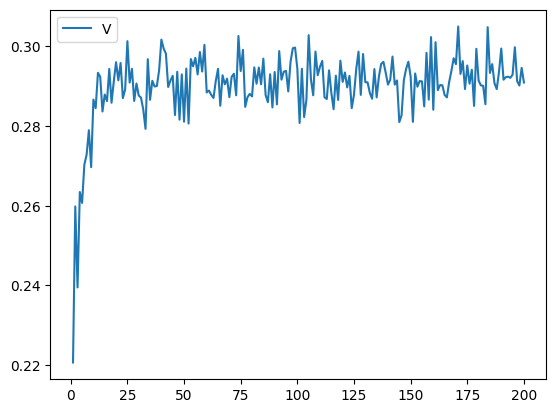

PyObject <matplotlib.legend.Legend object at 0x7f5f89de14a8>

In [19]:
using PyPlot
range = 1:200
plot(range, V[range], label="V")
legend()

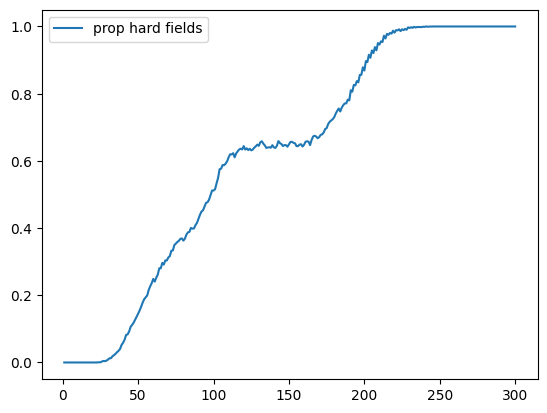

PyObject <matplotlib.legend.Legend object at 0x7f5f895fad30>

In [20]:
range = 1:300
plot(range, [p1[i][2] for i=range], label="prop hard fields")
legend()

* Try with a different initialization ?

In [21]:
q0=fill(NaN, 1:maxiter)
V=fill(NaN, 1:maxiter)
p1=fill((NaN, NaN), 1:maxiter)
pm1=fill((NaN, NaN), 1:maxiter)
maxiter=10^3
xmin=10^(-50)
ϵ=0.001
popP, popQ, q0, V, p1, pm1 = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, ϵ=ϵ, xmin=xmin)
popP

Progress: 100%|█████████████████████████████████████████| Time: 0:02:43


3×10000 OffsetArray(::Array{Tuple{Float64,Float64},2}, -1:1, 1:10000) with eltype Tuple{Float64,Float64} with indices -1:1×1:10000:
 (6.51149e-233, 1.0)     (0.0, 1.0)            …  (0.0, 1.0)
 (0.997747, 0.00225346)  (0.127854, 0.872146)     (0.00014841, 0.999852)
 (1.0, 1.08192e-235)     (1.0, 0.0)               (1.0, 0.0)

In [23]:
checkHardFields(popP, 10^(-50))

((0.0, 1.0), (1.0, 0.0))

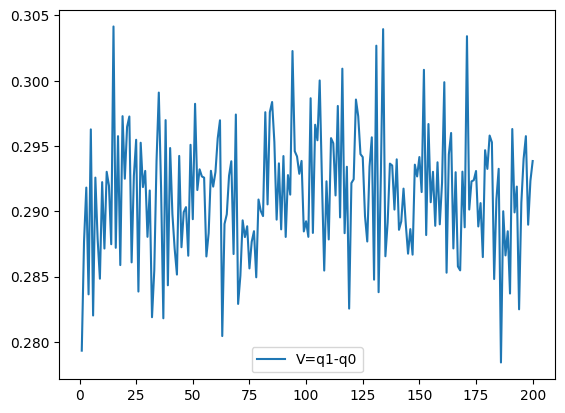

PyObject <matplotlib.legend.Legend object at 0x7f5f895d2668>

In [24]:
using PyPlot
range = 1:200
plot(range, V[range], label="V=q1-q0")
legend()

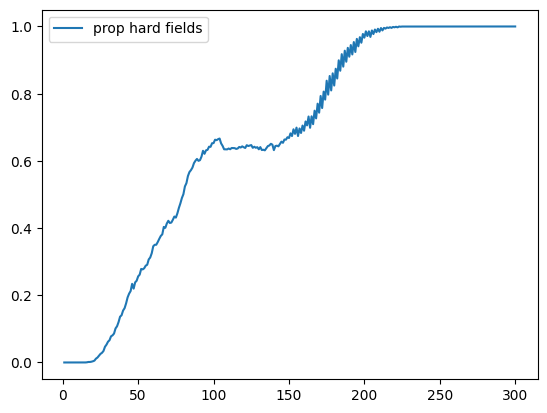

PyObject <matplotlib.legend.Legend object at 0x7f5f896facf8>

In [25]:
range = 1:300
plot(range, [p1[i][2] for i=range], label="prop hard fields")
legend()